**Week 10: Markovian Langevin Dynamics and Diffusion**

Jannek Schaffert, Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**

In this exercise, we explore the numerical integration of the Langevin equation (LE) to study Markovian dynamics and diffusion in a simplified particle system. The Langevin approach serves as a coarse-grained method for molecular dynamics (MD) simulations, significantly accelerating computations by incorporating friction and stochastic noise.





Importing all libraries used in this code.


In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit

import copy
import numpy as np
import scipy as scy
from tqdm import tqdm
import time


**Task 1: Implementation**

In this task, we implement a numerical integrator for the Langevin equation (LE) in two dimensions. The LE models the motion of a particle under the influence of friction and stochastic noise, described by:

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \Gamma \vec{v}_k \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right);
$

with

$
\vec{x}_{k+1} = \vec{x}_k + \vec{v}_k \Delta t
$,

where $k$: Step number,
$\Delta t$: time step,
$m$: particle mass,
$x$: position,
$v$: velocity,
$\Gamma$: friction constant,
$U$: potential energy,
$\vec{R}_k$: Gaussian random noise with zero mean and variance ( $\sigma^2 = 1 $)

As stated in the exercise sheet, the potential energy  $U$  is set to a constant throughout the simulation box. This simplifies the Langevin integrator. To observe this, we first rewrite the Langevin equation with the potential energy  $U$ :

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \frac{dU}{dx} \Delta t + \vec{v}_k \Gamma \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right)
$

Since  $U$  is constant, $\frac{\partial U}{\partial x} = 0$, and the equation simplifies to:

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \vec{v}_k \Gamma \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right)
$

with the position update given by:

$
\vec{x}_{k+1} = \vec{x}_k + \vec{v}_k \Delta t
$

.

These simplified equations are implemented in the code.


In [2]:

def langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, k_B=1.380649e-23, verbose=False):

    # Start timer
    start_time = time.time()

    # Initialise position and velocity arrays
    positions = np.zeros((steps, len(x0)))
    velocities = np.zeros((steps, len(v0)))

    # Set initial position and velocity
    positions[0] = x0
    velocities[0] = v0 # temperature accounted velocity will be added later on

    # calculate constants outside of loop to remove redundant calculations
    # speeds up by about 20 % for large loops
    const_1 = gamma * dt / mass
    const_2 = np.sqrt(2 * gamma * k_B * temp * dt) / mass

    # only use the "tqdm for loop" in verbose
    if verbose:
    # Loop over steps with tqdm
        for i in tqdm(range(steps - 1), desc="Running Langevin Integrator", unit="steps"):
            # Generate Gaussian random number around zero with stdv 1
            R = np.random.normal(0, 1, size=x0.shape)

            # Current velocity and position
            v = velocities[i]
            x = positions[i]

            # Update velocity and position
            v_next = v - const_1 * v + const_2 * R
            x_next = x + v_next * dt

            # Store the updated values
            velocities[i + 1] = v_next
            positions[i + 1] = x_next

    else:
        for i in (range(steps - 1)):
            # Generate Gaussian random number around zero with stdv 1
            R = np.random.normal(0, 1, size=x0.shape)

            # Current velocity and position
            v = velocities[i]
            x = positions[i]

            # Update velocity and position
            v_next = v - const_1 * v + const_2 * R
            x_next = x + v_next * dt

            # Store the updated values
            velocities[i + 1] = v_next
            positions[i + 1] = x_next

    # Verbose logging
    if verbose and i % 100 == 0:
        print(f"Step {i}: Position = {x_next}, Velocity = {v_next}")

    # End timer and print elapsed time
    end_time = time.time()
    print(f"Time elapsed: {end_time - start_time} seconds")

    return positions, velocities

**Task 2 - LE Simulation**

A particle with a mass of $m = 18$g/ mol and a starting velocity corresponding to a temperature of $T = 293.15$K in a random direction is assigned to the particle.
The friction constant is set to 50 kg/(mol * ns) and the simulation is run for 1 Mio steps.


In [3]:
# Parameters
steps = 1000000 # 1 Mio
dt = 1.0e-6 # ns
kB = 1.380649e-23
mass = 0.018  # kg/mol
gamma = 50  # Friction constant kg/(mol ns)
temp = 293.15  # Kelvin

x0 = np.array([0.0, 0.0])  # Initial position (2D) in nm

# initial velocity should be according to a temperature of 293.15 K
def get_velocity_with_temperature(temperature, kB, mass):

    v0_magnitude = np.sqrt((kB * temp)/mass)
    random_angle = np.random.uniform(0, 2 * np.pi)
    v0 = np.array([v0_magnitude * np.cos(random_angle), v0_magnitude * np.sin(random_angle)])
    return v0

v0 = get_velocity_with_temperature(temp, kB, mass)



In [4]:
# Run simulation
positions, velocities = langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, verbose=True)

# just to check the initial velocity
print(f'Initial Velocity: ', velocities[0])


Running Langevin Integrator: 100%|██████████| 999999/999999 [00:18<00:00, 55292.72steps/s]

Time elapsed: 18.10983395576477 seconds
Initial Velocity:  [ 1.43478349e-10 -4.51960168e-10]


From the elapsed time we can see that this simulation is significantly faster than previous MD simulations.

Plotting the position evolution from the simulation for visualisation.

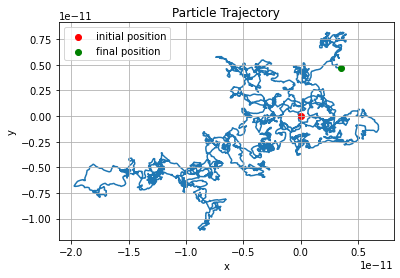

In [5]:

# z order makes sure the initial and final position dots are on top of the trajectory

plt.plot(positions[:, 0], positions[:, 1], zorder=0)
plt.scatter(positions[0,0], positions[0,1], label="initial position", color="red", zorder=1)
plt.scatter(positions[-1,0], positions[-1,1], label="final position", color="green", zorder=1)
plt.title("Particle Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()



**Task 3 - Determination of diffusion coefficient**

In this task, we calculate the two-dimensional diffusion coefficient $ D(t)$  using the particle trajectories obtained from the Langevin simulation. The diffusion coefficient is determined by analyzing the mean squared displacement of the particle over time.

The MSD is defined as:

$
MSD(t) = \Delta \vec{x}(t)^2 = \left\langle (\vec{x}(t) - \vec{x}(t_0))^2 \right\rangle
$,

where  $\vec{x}(t_0)$  is the initial position of the particle. The diffusion coefficient  $D(t)$  is then calculated as:

$
D(t) = \frac{MSD(t)}{4t}
$.


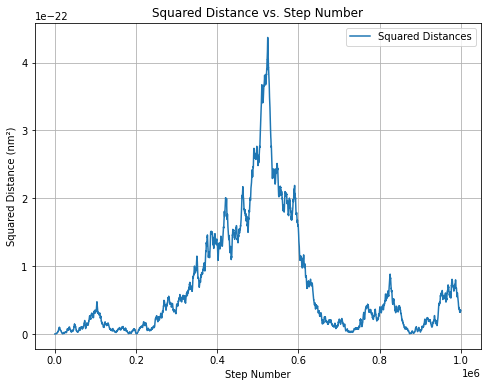

In [6]:
def calculate_distance_squared(positions):
    initial_positions = positions[0,:]
    displacements = positions - initial_positions
    squared_distances = np.sum(displacements ** 2, axis=1)
    return squared_distances

p = calculate_distance_squared(positions)

plt.figure(figsize=(8, 6))
plt.plot(range(len(p)), p, label="Squared Distances")
plt.xlabel("Step Number")
plt.ylabel("Squared Distance (nm²)")
plt.title("Squared Distance vs. Step Number")
plt.grid()
plt.legend()
plt.show()



In this specific example, as we can see from the earlier walk of the particle the distance first increases and then decreases as the particle moves closer to its origin. To get a Result that we can work with, we are going to repeat the simulation to calculate averaged (!) squared differences. Thus, we should be able to visualise a trend.

In [7]:
number_of_simulations = 100 # don't go to big, this takes X times the above simulation!

# Array to store squared distances for all simulations
squared_distanced = np.zeros(steps)

for i in tqdm(range(number_of_simulations), desc="Running simulations"):
    x0 = np.array([0.0, 0.0])  # Reset initial position
    v0 = get_velocity_with_temperature(temp, kB, mass)  # Generate initial velocity
    positions, _ = langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, verbose=False)

    # Calculate squared distance from the origin for this simulation
    squared_distanced = squared_distanced + np.sum(positions ** 2, axis=1)

# Divide by the number of simulations to get the mean
squared_distanced = squared_distanced / number_of_simulations


Running simulations:   1%|          | 1/100 [00:17<28:35, 17.33s/it]

Time elapsed: 17.291136026382446 seconds


Running simulations:   2%|▏         | 2/100 [00:34<28:24, 17.40s/it]

Time elapsed: 17.508183002471924 seconds


Running simulations:   3%|▎         | 3/100 [00:52<28:22, 17.55s/it]

Time elapsed: 17.862006902694702 seconds


Running simulations:   4%|▍         | 4/100 [01:10<28:04, 17.55s/it]

Time elapsed: 17.49531579017639 seconds


Running simulations:   5%|▌         | 5/100 [01:29<28:37, 18.07s/it]

Time elapsed: 19.25046992301941 seconds


Running simulations:   6%|▌         | 6/100 [01:46<27:58, 17.86s/it]

Time elapsed: 17.309770107269287 seconds


Running simulations:   7%|▋         | 7/100 [02:04<27:28, 17.72s/it]

Time elapsed: 17.372234106063843 seconds


Running simulations:   8%|▊         | 8/100 [02:21<27:04, 17.66s/it]

Time elapsed: 17.468816995620728 seconds


Running simulations:   9%|▉         | 9/100 [02:39<26:37, 17.55s/it]

Time elapsed: 17.2696430683136 seconds


Running simulations:  10%|█         | 10/100 [02:56<26:15, 17.51s/it]

Time elapsed: 17.381000995635986 seconds


Running simulations:  11%|█         | 11/100 [03:14<25:55, 17.48s/it]

Time elapsed: 17.364710092544556 seconds


Running simulations:  12%|█▏        | 12/100 [03:31<25:38, 17.48s/it]

Time elapsed: 17.44992995262146 seconds


Running simulations:  13%|█▎        | 13/100 [03:49<25:45, 17.76s/it]

Time elapsed: 18.375847816467285 seconds


Running simulations:  14%|█▍        | 14/100 [04:07<25:19, 17.67s/it]

Time elapsed: 17.406275749206543 seconds


Running simulations:  15%|█▌        | 15/100 [04:24<24:51, 17.54s/it]

Time elapsed: 17.226524114608765 seconds


Running simulations:  16%|█▌        | 16/100 [04:43<25:12, 18.01s/it]

Time elapsed: 19.04213309288025 seconds


Running simulations:  17%|█▋        | 17/100 [05:01<24:36, 17.79s/it]

Time elapsed: 17.258638858795166 seconds


Running simulations:  18%|█▊        | 18/100 [05:18<24:11, 17.70s/it]

Time elapsed: 17.423757076263428 seconds


Running simulations:  19%|█▉        | 19/100 [05:38<24:55, 18.46s/it]

Time elapsed: 20.19263005256653 seconds


Running simulations:  20%|██        | 20/100 [05:57<24:34, 18.43s/it]

Time elapsed: 18.317598342895508 seconds


Running simulations:  21%|██        | 21/100 [06:14<23:58, 18.21s/it]

Time elapsed: 17.627590894699097 seconds


Running simulations:  22%|██▏       | 22/100 [06:32<23:27, 18.05s/it]

Time elapsed: 17.61352801322937 seconds


Running simulations:  23%|██▎       | 23/100 [06:49<22:55, 17.86s/it]

Time elapsed: 17.380186080932617 seconds


Running simulations:  24%|██▍       | 24/100 [07:07<22:27, 17.73s/it]

Time elapsed: 17.37531805038452 seconds


Running simulations:  25%|██▌       | 25/100 [07:24<22:02, 17.64s/it]

Time elapsed: 17.378467798233032 seconds


Running simulations:  26%|██▌       | 26/100 [07:41<21:36, 17.52s/it]

Time elapsed: 17.19600486755371 seconds


Running simulations:  27%|██▋       | 27/100 [07:59<21:16, 17.48s/it]

Time elapsed: 17.35465407371521 seconds


Running simulations:  28%|██▊       | 28/100 [08:16<21:01, 17.52s/it]

Time elapsed: 17.54883885383606 seconds


Running simulations:  29%|██▉       | 29/100 [08:34<20:41, 17.49s/it]

Time elapsed: 17.37873101234436 seconds


Running simulations:  30%|███       | 30/100 [08:51<20:20, 17.44s/it]

Time elapsed: 17.29953384399414 seconds


Running simulations:  31%|███       | 31/100 [09:09<20:03, 17.44s/it]

Time elapsed: 17.395055294036865 seconds


Running simulations:  32%|███▏      | 32/100 [09:26<19:46, 17.44s/it]

Time elapsed: 17.439476013183594 seconds


Running simulations:  33%|███▎      | 33/100 [09:44<19:29, 17.45s/it]

Time elapsed: 17.439226150512695 seconds


Running simulations:  34%|███▍      | 34/100 [10:01<19:11, 17.44s/it]

Time elapsed: 17.37360191345215 seconds


Running simulations:  35%|███▌      | 35/100 [10:18<18:52, 17.42s/it]

Time elapsed: 17.335288047790527 seconds


Running simulations:  36%|███▌      | 36/100 [10:36<18:36, 17.44s/it]

Time elapsed: 17.4612820148468 seconds


Running simulations:  37%|███▋      | 37/100 [10:53<18:17, 17.43s/it]

Time elapsed: 17.356428861618042 seconds


Running simulations:  38%|███▊      | 38/100 [11:11<17:59, 17.42s/it]

Time elapsed: 17.363391876220703 seconds


Running simulations:  39%|███▉      | 39/100 [11:28<17:35, 17.31s/it]

Time elapsed: 17.02912998199463 seconds


Running simulations:  40%|████      | 40/100 [11:45<17:19, 17.33s/it]

Time elapsed: 17.3463077545166 seconds


Running simulations:  41%|████      | 41/100 [12:02<17:00, 17.30s/it]

Time elapsed: 17.201369047164917 seconds


Running simulations:  42%|████▏     | 42/100 [12:20<16:47, 17.37s/it]

Time elapsed: 17.477926015853882 seconds


Running simulations:  43%|████▎     | 43/100 [12:37<16:29, 17.37s/it]

Time elapsed: 17.328925848007202 seconds


Running simulations:  44%|████▍     | 44/100 [12:55<16:14, 17.40s/it]

Time elapsed: 17.449599981307983 seconds


Running simulations:  45%|████▌     | 45/100 [13:12<15:57, 17.40s/it]

Time elapsed: 17.38245725631714 seconds


Running simulations:  46%|████▌     | 46/100 [13:29<15:38, 17.37s/it]

Time elapsed: 17.284741163253784 seconds


Running simulations:  47%|████▋     | 47/100 [13:47<15:20, 17.37s/it]

Time elapsed: 17.30691885948181 seconds


Running simulations:  48%|████▊     | 48/100 [14:04<15:04, 17.39s/it]

Time elapsed: 17.42556381225586 seconds


Running simulations:  49%|████▉     | 49/100 [14:22<14:47, 17.39s/it]

Time elapsed: 17.37217926979065 seconds


Running simulations:  50%|█████     | 50/100 [14:39<14:29, 17.39s/it]

Time elapsed: 17.36104989051819 seconds


Running simulations:  51%|█████     | 51/100 [14:56<14:11, 17.38s/it]

Time elapsed: 17.3263578414917 seconds


Running simulations:  52%|█████▏    | 52/100 [15:14<13:54, 17.39s/it]

Time elapsed: 17.377864837646484 seconds


Running simulations:  53%|█████▎    | 53/100 [15:31<13:37, 17.40s/it]

Time elapsed: 17.38879895210266 seconds


Running simulations:  54%|█████▍    | 54/100 [15:49<13:21, 17.42s/it]

Time elapsed: 17.428213357925415 seconds


Running simulations:  55%|█████▌    | 55/100 [16:06<13:03, 17.42s/it]

Time elapsed: 17.396104097366333 seconds


Running simulations:  56%|█████▌    | 56/100 [16:23<12:47, 17.43s/it]

Time elapsed: 17.438806772232056 seconds


Running simulations:  57%|█████▋    | 57/100 [16:41<12:29, 17.42s/it]

Time elapsed: 17.37153911590576 seconds


Running simulations:  58%|█████▊    | 58/100 [16:58<12:13, 17.45s/it]

Time elapsed: 17.498023748397827 seconds


Running simulations:  59%|█████▉    | 59/100 [17:16<11:56, 17.47s/it]

Time elapsed: 17.466092109680176 seconds


Running simulations:  60%|██████    | 60/100 [17:33<11:37, 17.44s/it]

Time elapsed: 17.358137845993042 seconds


Running simulations:  61%|██████    | 61/100 [17:50<11:17, 17.36s/it]

Time elapsed: 17.139322996139526 seconds


Running simulations:  62%|██████▏   | 62/100 [18:07<10:55, 17.25s/it]

Time elapsed: 16.970094203948975 seconds


Running simulations:  63%|██████▎   | 63/100 [18:25<10:40, 17.31s/it]

Time elapsed: 17.401609897613525 seconds


Running simulations:  64%|██████▍   | 64/100 [18:42<10:24, 17.36s/it]

Time elapsed: 17.43656086921692 seconds


Running simulations:  65%|██████▌   | 65/100 [19:00<10:07, 17.34s/it]

Time elapsed: 17.291561126708984 seconds


Running simulations:  66%|██████▌   | 66/100 [19:17<09:54, 17.48s/it]

Time elapsed: 17.741441011428833 seconds


Running simulations:  67%|██████▋   | 67/100 [19:35<09:35, 17.45s/it]

Time elapsed: 17.339571952819824 seconds


Running simulations:  68%|██████▊   | 68/100 [19:52<09:17, 17.42s/it]

Time elapsed: 17.329266786575317 seconds


Running simulations:  69%|██████▉   | 69/100 [20:10<09:00, 17.42s/it]

Time elapsed: 17.397252082824707 seconds


Running simulations:  70%|███████   | 70/100 [20:29<08:57, 17.92s/it]

Time elapsed: 19.014630794525146 seconds


Running simulations:  71%|███████   | 71/100 [20:46<08:34, 17.73s/it]

Time elapsed: 17.255846977233887 seconds


Running simulations:  72%|███████▏  | 72/100 [21:03<08:14, 17.66s/it]

Time elapsed: 17.45070505142212 seconds


Running simulations:  73%|███████▎  | 73/100 [21:21<07:52, 17.51s/it]

Time elapsed: 17.136927843093872 seconds


Running simulations:  74%|███████▍  | 74/100 [21:38<07:33, 17.44s/it]

Time elapsed: 17.237960815429688 seconds


Running simulations:  75%|███████▌  | 75/100 [21:56<07:17, 17.49s/it]

Time elapsed: 17.594528913497925 seconds


Running simulations:  76%|███████▌  | 76/100 [22:13<06:59, 17.48s/it]

Time elapsed: 17.423063039779663 seconds


Running simulations:  77%|███████▋  | 77/100 [22:30<06:41, 17.48s/it]

Time elapsed: 17.430325031280518 seconds


Running simulations:  78%|███████▊  | 78/100 [22:48<06:26, 17.57s/it]

Time elapsed: 17.76833987236023 seconds


Running simulations:  79%|███████▉  | 79/100 [23:06<06:07, 17.52s/it]

Time elapsed: 17.3511700630188 seconds


Running simulations:  80%|████████  | 80/100 [23:23<05:49, 17.47s/it]

Time elapsed: 17.3402841091156 seconds


Running simulations:  81%|████████  | 81/100 [23:40<05:31, 17.42s/it]

Time elapsed: 17.28676414489746 seconds


Running simulations:  82%|████████▏ | 82/100 [23:58<05:12, 17.37s/it]

Time elapsed: 17.207942962646484 seconds


Running simulations:  83%|████████▎ | 83/100 [24:15<04:55, 17.39s/it]

Time elapsed: 17.413509130477905 seconds


Running simulations:  84%|████████▍ | 84/100 [24:32<04:38, 17.39s/it]

Time elapsed: 17.35696506500244 seconds


Running simulations:  85%|████████▌ | 85/100 [24:50<04:20, 17.38s/it]

Time elapsed: 17.325111865997314 seconds


Running simulations:  86%|████████▌ | 86/100 [25:07<04:03, 17.39s/it]

Time elapsed: 17.414183855056763 seconds


Running simulations:  87%|████████▋ | 87/100 [25:25<03:46, 17.39s/it]

Time elapsed: 17.34382176399231 seconds


Running simulations:  88%|████████▊ | 88/100 [25:42<03:28, 17.38s/it]

Time elapsed: 17.346314907073975 seconds


Running simulations:  89%|████████▉ | 89/100 [25:59<03:11, 17.40s/it]

Time elapsed: 17.416515111923218 seconds


Running simulations:  90%|█████████ | 90/100 [26:17<02:54, 17.42s/it]

Time elapsed: 17.44999885559082 seconds


Running simulations:  91%|█████████ | 91/100 [26:34<02:36, 17.40s/it]

Time elapsed: 17.322004318237305 seconds


Running simulations:  92%|█████████▏| 92/100 [26:52<02:19, 17.41s/it]

Time elapsed: 17.413121938705444 seconds


Running simulations:  93%|█████████▎| 93/100 [27:09<02:01, 17.41s/it]

Time elapsed: 17.3703830242157 seconds


Running simulations:  94%|█████████▍| 94/100 [27:26<01:44, 17.38s/it]

Time elapsed: 17.28552508354187 seconds


Running simulations:  95%|█████████▌| 95/100 [27:44<01:26, 17.35s/it]

Time elapsed: 17.253588914871216 seconds


Running simulations:  96%|█████████▌| 96/100 [28:01<01:09, 17.35s/it]

Time elapsed: 17.31715703010559 seconds


Running simulations:  97%|█████████▋| 97/100 [28:18<00:52, 17.36s/it]

Time elapsed: 17.380186080932617 seconds


Running simulations:  98%|█████████▊| 98/100 [28:36<00:34, 17.38s/it]

Time elapsed: 17.377408981323242 seconds


Running simulations:  99%|█████████▉| 99/100 [28:53<00:17, 17.36s/it]

Time elapsed: 17.313010931015015 seconds


Running simulations: 100%|██████████| 100/100 [29:10<00:00, 17.51s/it]

Time elapsed: 17.36437177658081 seconds


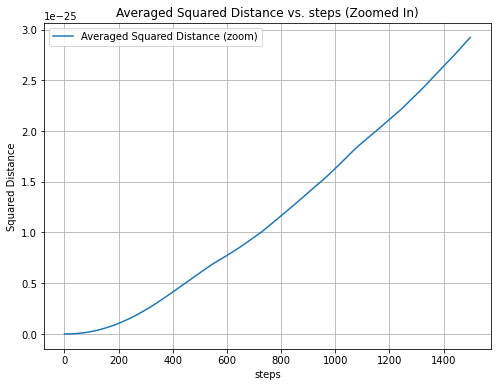

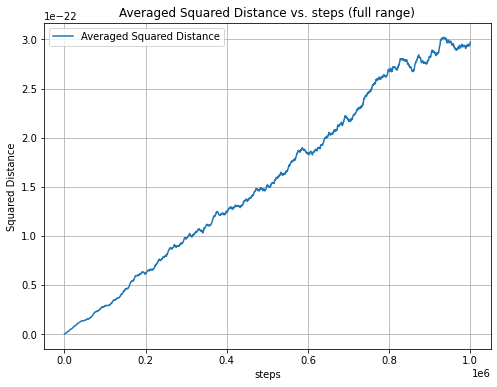

In [13]:

# Plot for very small times
plt.figure(figsize=(8, 6))
plt.plot(squared_distanced[:1500], label="Averaged Squared Distance (zoom)")
plt.xlabel("steps")
plt.ylabel("Squared Distance")
plt.title("Averaged Squared Distance vs. steps (Zoomed In)")
plt.grid()
plt.legend()
plt.show()

# Plot for the entire range
plt.figure(figsize=(8, 6))
plt.plot(squared_distanced, label="Averaged Squared Distance")
plt.xlabel("steps")
plt.ylabel("Squared Distance")
plt.title("Averaged Squared Distance vs. steps (full range)")
plt.grid()
plt.legend()
plt.show()

I think we can see the initial ballistic evolution converging to something linear after about 1500 Steps.

In [14]:
# Calculate D
Ds = squared_distanced[1:] / (4 * np.arange(1, np.shape(squared_distanced)[0]) * dt)

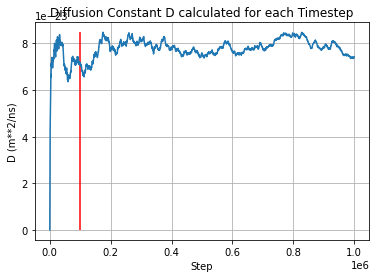

In [15]:
# Plot D
cut = 100000
plt.plot(Ds)
plt.vlines(cut, np.min(Ds), np.max(Ds), color='r')
plt.title('Diffusion Constant D calculated for each Timestep')
plt.grid()
plt.xlabel('Step')
plt.ylabel('D (m**2/ns)')
plt.show()



In [16]:
# Determine Difussion Constant
D = np.mean(Ds[cut:])
print(f'We obtain a Diffusion Constant D = {D:} m*2/ns after a cut of {cut}')

We obtain a Diffusion Constant D = 7.831557772703595e-23 m*2/ns after a cut of 100000


$
\Gamma = \frac{k_B T}{D}
$
Einstein equation

In [17]:
# Calculate Friction Coefficiant using the einstein equation
gamma_new = kB * temp / D
print(f'We have for gamma (N*ns/(mol*m)):\nInput: {gamma:.3f}\nRcalculated: {gamma_new:.3f}')

We have for gamma (N*ns/(mol*m)):
Input: 50.000
Rcalculated: 51.680


That's not exactly the same but pretty close. Especially when you consider we only averaged 100 runs. Errors might be due to just 100 simulations. More simulations take too long. One probably has to optimise the code and then do like 1000 simulations.